In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
from plaid.datasets import CATHShardedDataModule

shard_dir = "/homefs/home/lux70/storage/data/rocklin/shards/"
dm = CATHShardedDataModule(storage_type="hdf5", shard_dir=shard_dir, seq_len=256, batch_size=1976)
dm.setup()
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

In [24]:
print(len(train_dataloader.dataset))
print(len(val_dataloader.dataset))

train_batch = next(iter(train_dataloader))
val_batch = next(iter(val_dataloader))

print(train_batch[0].shape)
print(val_batch[0].shape)


7904
1976
torch.Size([1976, 43, 1024])
torch.Size([1976, 43, 1024])


In [25]:
from plaid.evaluation import calc_fid_fn, parmar_fid

# Unnormalized raw latent

In [26]:
print(train_batch[0].mean(), train_batch[0].std())
print(val_batch[0].mean(), val_batch[0].std())

tensor(1.1961) tensor(71.3851)
tensor(1.1991) tensor(71.4518)


In [27]:
calc_fid_fn(train_batch[0].mean(dim=1), val_batch[0].mean(dim=1))

tensor(-200.1610)

In [28]:
# try a different implementation
parmar_fid(train_batch[0].mean(dim=1).numpy(), val_batch[0].mean(dim=1).numpy())

Imaginary component 0.0029816698803220455


nan

# Squish to [-1, 1] range

In [29]:
from plaid.utils import LatentScaler
scaler = LatentScaler()

In [30]:
scaled_train = scaler.scale(train_batch[0])
scaled_val = scaler.scale(val_batch[0])

In [31]:
print(scaled_train.max())
print(scaled_train.min())
print(scaled_train.mean())
print(scaled_train.std())

tensor(1.0689)
tensor(-1.0252)
tensor(-0.0052)
tensor(0.1865)


In [32]:
print(scaled_val.max())
print(scaled_val.min())
print(scaled_val.mean())
print(scaled_val.std())

tensor(1.1002)
tensor(-1.1092)
tensor(-0.0051)
tensor(0.1867)


In [33]:
calc_fid_fn(scaled_train.mean(dim=1), scaled_val.mean(dim=1))

tensor(-0.0066)

In [34]:
# try dif implementation
parmar_fid(scaled_train.mean(dim=1).numpy(), scaled_val.mean(dim=1).numpy())

0.04311427881934016

In [35]:
from plaid.evaluation import parmar_kid

parmar_kid(scaled_train.mean(dim=1).numpy(), scaled_val.mean(dim=1).numpy())

9.108971471368932e-07

# Compare to UniRef

In [30]:
from plaid.constants import CACHED_TENSORS_DIR
from pathlib import Path
from safetensors.torch import load_file

In [37]:
uniref_holdout = load_file(Path(CACHED_TENSORS_DIR) / "holdout_esmfold_feats.st")['features']
cath_holdout = load_file(Path(CACHED_TENSORS_DIR) / "cath_esmfold_feats.st")['embeddings']

scaled_uniref = scaler.scale(uniref_holdout)
scaled_cath = scaler.scale(cath_holdout)

In [38]:
parmar_fid(
    scaled_train.mean(dim=1).numpy(),
    scaled_uniref.numpy(),
)

8.382239767818914

In [39]:
parmar_kid(
    scaled_train.mean(dim=1).numpy(),
    scaled_uniref.numpy(),
)

0.01907546199324326

# Compare to CATH

In [42]:
parmar_fid(
    scaled_train.mean(dim=1).numpy(),
    scaled_cath.mean(dim=1).numpy(),
)

6.866759709475925

In [43]:
parmar_kid(
    scaled_train.mean(dim=1).numpy(),
    scaled_cath.mean(dim=1).numpy(),
)

0.011983237093343315

# Predict ESMFold structures

In [59]:
from plaid.esmfold import esmfold_v1
esmfold = esmfold_v1()
device = "cuda"
esmfold = esmfold.to(device).eval()

## From Sequence (higher fidelity)

In [7]:
from plaid.esmfold.misc import output_to_pdb

# all_pdbs = []
# all_outputs = []

import torch
from plaid.datasets import CATHShardedDataModule

batch_size = 256

shard_dir = "/homefs/home/lux70/storage/data/rocklin/shards/"
dm = CATHShardedDataModule(storage_type="hdf5", shard_dir=shard_dir, seq_len=256, batch_size=batch_size)
dm.setup()
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()


In [75]:
from tqdm.notebook import tqdm, trange

In [77]:


for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
    # if i > 3:
    #     break
        
    with torch.no_grad():
        sequences = batch[1]
        headers = batch[2]
        outputs = esmfold.infer(sequences)
        pdbs = output_to_pdb(outputs)

        for pdbstr, header in tqdm(zip(pdbs, headers), total=batch_size):
            # header already has the pdb ending, sadly
            with open(f"rocklin_predicted_structures/{header}", "w") as f:
                f.write(pdbstr)
    

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [9]:
len(val_dataloader.dataset)

1976

In [11]:
# extract average b factors (pLDDT) for the predicted structures
import glob
new_location = "/homefs/home/lux70/storage/data/rocklin/esmfold_predicted_structures/val/"
files = glob.glob(f"{new_location}/*.pdb*")
print(len(files))

1976


In [17]:
from plaid.utils import extract_avg_b_factor_per_residue
import numpy as np

mean_rocklin_plddts = [np.mean(extract_avg_b_factor_per_residue(f)) for f in files]

Text(0.5, 1.0, 'Average ESMFold pLDDTs for Rocklin Mini-Protein Dataset')

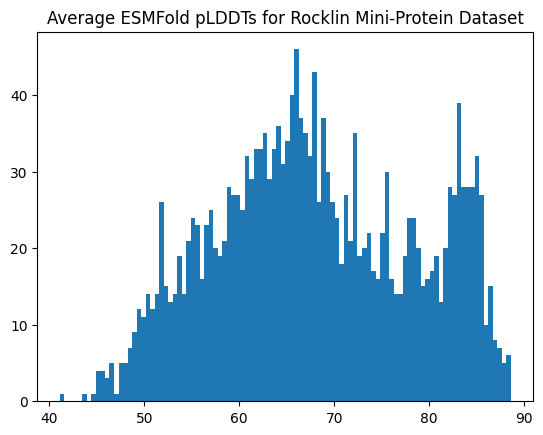

In [22]:
import matplotlib.pyplot as plt
_ = plt.hist(mean_rocklin_plddts, bins=100)
plt.title("Average ESMFold pLDDTs for Rocklin Mini-Protein Dataset")

In [21]:
print(np.mean(mean_rocklin_plddts))
print(np.std(mean_rocklin_plddts))

68.03653016039135
10.517112370988627


# Verify Consistency w/ Structure from Latent


In [49]:
from plaid.proteins import LatentToStructure
structure_constructor = LatentToStructure()
device = "cuda"
structure_constructor.to(device)

In [64]:
pdbstrs, metrics = structure_constructor.to_structure(val_batch[0][:10, ...], val_batch[1][:10], num_recycles=4)

Generating structure from latents


In [65]:
val_batch[2][:10]

['HEEH_rd3_0742.pdb_buryD',
 'EEHEE_rd3_1081.pdb_PG_hp',
 'EEHEE_rd1_0948.pdb_random',
 'HEEH_rd2_0232.pdb',
 'HEEH_rd2_0511.pdb',
 'HHH_rd3_0019.pdb_buryD',
 'HEEH_rd1_0849.pdb',
 'EEHEE_rd2_0242.pdb_buryD',
 'EEHEE_rd3_0752.pdb_buryD',
 'HHH_rd3_0045.pdb_PG_hp']

In [66]:
metrics['plddt'].mean()

59.281017

In [67]:
# check for overlap
from plaid.utils import view_py3Dmol
import py3Dmol

for i in range(10):
    latent_recons_pdb = pdbstrs[i]
    with open(f"{new_location}{val_batch[2][i]}", "r") as f:
        pred_pdb = f.read()
        
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(latent_recons_pdb)
    view.addModelsAsFrames(pred_pdb)
    view.setStyle({"model": 0}, {"cartoon": {"color": "blue"}})
    view.setStyle({"model": 1}, {"cartoon": {"color": "green"}})
    view.zoomTo()
    view.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol